In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from aeon.datasets import load_classification

In [2]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

In [63]:
dataset = 'StarLightCurves'

X_train, y_train = load_classification(dataset, split="train")

X_test, y_test = load_classification(dataset, split="test")



print(f"Shape treino: {X_train.shape}")

print(f"Shape teste: {X_test.shape}")

Shape treino: (1000, 1, 1024)
Shape teste: (8236, 1, 1024)


In [46]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Shape achatado: {X_train_flat.shape}")

Shape achatado: (40, 2000)


In [47]:
X_train_tensor = torch.FloatTensor(X_train_flat)
X_test_tensor = torch.FloatTensor(X_test_flat)

In [48]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
input_dim = X_train_flat.shape[1]
bottleneck_percent = 0.5  # 50% do tamanho original
latent_dim = int(input_dim * bottleneck_percent)

In [50]:
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nModelo: {input_dim} -> {latent_dim} -> {input_dim}")


Modelo: 2000 -> 1000 -> 2000


In [51]:
# Treinar
num_epochs = 100

print("Treinando...")
for epoch in range(num_epochs):
    for data, _ in train_loader:
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Treinamento concluído!")

Treinando...
Treinamento concluído!


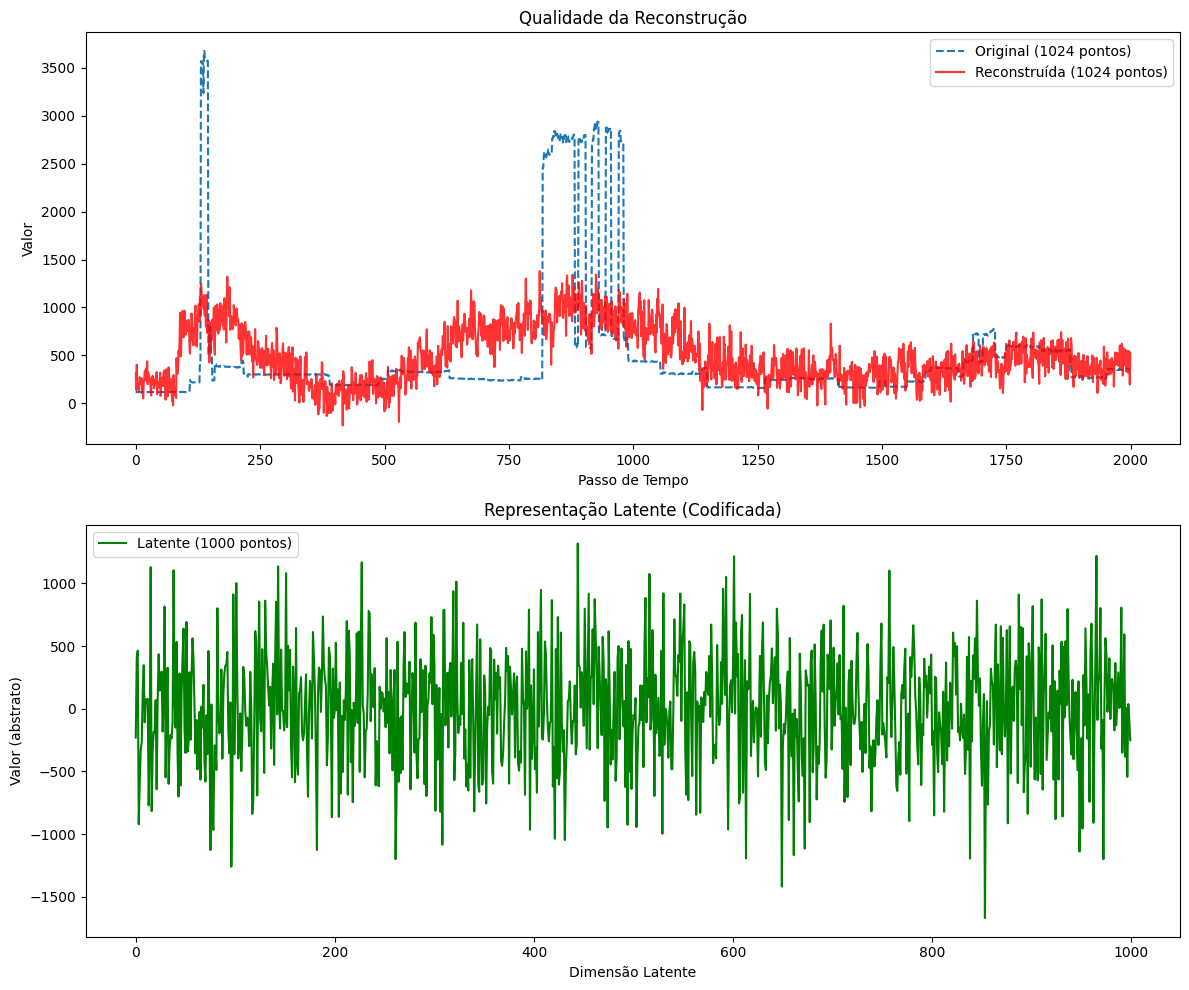

In [52]:
# Obter as três versões da série
model.eval()
with torch.no_grad():
    # Pegue a amostra (índice 20)
    original_data = X_test_tensor[20]
    
    # Versão Latente (Codificada)
    latent_data = model.encode(original_data).numpy()
    
    # Versão Reconstruída
    # (Passa pelo encoder E pelo decoder)
    reconstructed_data = model(original_data).numpy() 

# Plotar tudo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Gráfico 1: Original vs. Reconstruída ---
ax1.plot(original_data.numpy(), label='Original (1024 pontos)', linestyle='--')
ax1.plot(reconstructed_data, label='Reconstruída (1024 pontos)', color='red', alpha=0.8)
ax1.legend()
ax1.set_title('Qualidade da Reconstrução')
ax1.set_xlabel('Passo de Tempo')
ax1.set_ylabel('Valor')

# --- Gráfico 2: A Representação Latente ---
ax2.plot(latent_data, label=f'Latente ({latent_dim} pontos)', color='green')
ax2.legend()
ax2.set_title('Representação Latente (Codificada)')
ax2.set_xlabel('Dimensão Latente')
ax2.set_ylabel('Valor (abstrato)')

plt.tight_layout()
plt.show()

In [64]:
# (batch, features, seq_len)
X_train_cnn_tensor = torch.FloatTensor(X_train)
X_test_cnn_tensor = torch.FloatTensor(X_test)

train_cnn_dataset = TensorDataset(X_train_cnn_tensor, X_train_cnn_tensor)
train_cnn_loader = DataLoader(train_cnn_dataset, batch_size=32, shuffle=True)

print(f"Shape dos dados de treino para o CNN: {X_train_cnn_tensor.shape}")

Shape dos dados de treino para o CNN: torch.Size([1000, 1, 1024])


In [260]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder (Comprime a dimensão do tempo)
        self.encoder = nn.Sequential(
            # Entrada: [B, 1, 1024] (B=Batch, C=Canais/Features, L=Comprimento)
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=7, stride=2)
        )
        
        # Decoder (Expande a dimensão do tempo)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=7, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=7, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=7, stride=2, output_padding=1)
        )

    def encode(self, x):
        return self.encoder(x)
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        
        # Ajuste de tamanho para garantir que a saída tenha o mesmo comprimento da entrada
        if reconstructed.shape[-1] > x.shape[-1]:
            reconstructed = reconstructed[..., :x.shape[-1]]
        elif reconstructed.shape[-1] < x.shape[-1]:
            pad = x.shape[-1] - reconstructed.shape[-1]
            reconstructed = nn.functional.pad(reconstructed, (0, pad))
        return reconstructed

In [261]:
model_cnn = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

print("Treinando 1D-CNN Autoencoder...")
print(f"Dados de entrada shape: {X_train_cnn_tensor.shape}")

# Loop de Treinamento
num_epochs = 70
train_losses_cnn = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data, _ in train_cnn_loader:
        # --- Forward Pass ---
        output = model_cnn(data)
        loss = criterion(output, data)
        
        # --- Backward Pass ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # --- Log ---
    avg_loss = epoch_loss / len(train_cnn_loader)
    train_losses_cnn.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

print("Treinamento 1D-CNN concluído!")

Treinando 1D-CNN Autoencoder...
Dados de entrada shape: torch.Size([1000, 1, 1024])
Epoch [10/70], Loss: 0.008959
Epoch [20/70], Loss: 0.004851
Epoch [30/70], Loss: 0.002917
Epoch [40/70], Loss: 0.002342
Epoch [50/70], Loss: 0.002144
Epoch [60/70], Loss: 0.002181
Epoch [70/70], Loss: 0.002041
Treinamento 1D-CNN concluído!


Shape da Série Original: (1024,)
Shape da Série Reconstruída: (1024,)
Shape do Espaço Latente (Canais, Tempo): (32, 123)
Shape da linha média latente: (123,)
Shape da linha máxima latente: (123,)


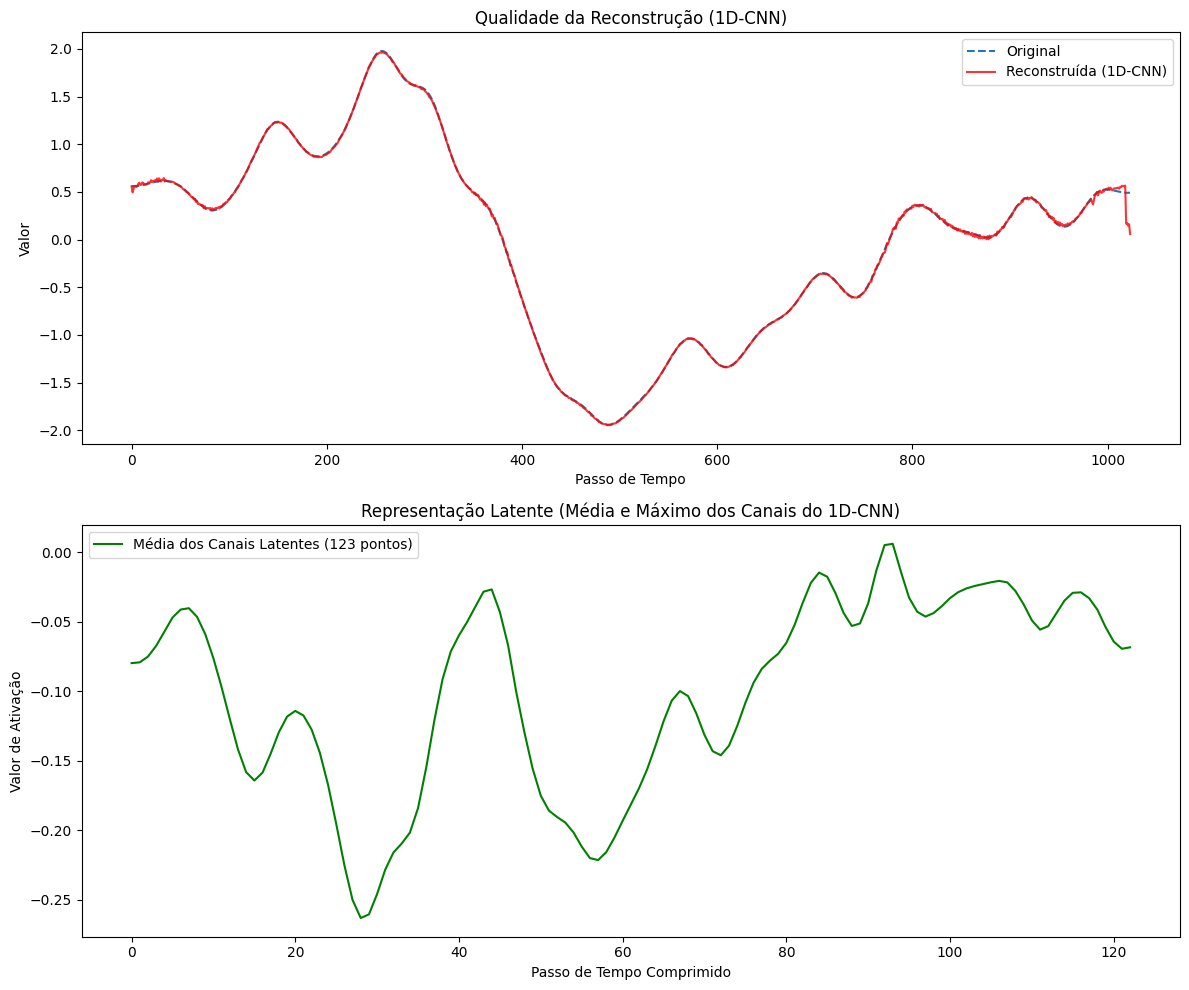

In [262]:
# 1. Colocar o modelo em modo de avaliação
model_cnn.eval()

with torch.no_grad():
    # 2. Pegar a amostra de teste (índice 22)
    original_sample_cnn = X_test_cnn_tensor[22:23] # Shape: [1, 1, 1024]
    
    # 3. Obter a Versão Latente (Codificada)
    latent_data_cnn = model_cnn.encode(original_sample_cnn) # Shape: [1, 64, 128]
    
    # 4. Obter a Versão Reconstruída
    reconstructed_data_cnn = model_cnn(original_sample_cnn) # Shape: [1, 1, 1024]

# 5. Preparar os dados para o plot
original_to_plot = original_sample_cnn.squeeze().numpy()
reconstructed_to_plot = reconstructed_data_cnn.squeeze().numpy()
latent_to_plot = latent_data_cnn.squeeze().numpy() # Shape: [64, 128]

print(f"Shape da Série Original: {original_to_plot.shape}")
print(f"Shape da Série Reconstruída: {reconstructed_to_plot.shape}")
print(f"Shape do Espaço Latente (Canais, Tempo): {latent_to_plot.shape}")

# 6. Plotar tudo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# --- Gráfico 1: Original vs. Reconstruída (1D-CNN) ---
ax1.plot(original_to_plot, label='Original', linestyle='--')
ax1.plot(reconstructed_to_plot, label='Reconstruída (1D-CNN)', color='red', alpha=0.8)
ax1.legend()
ax1.set_title('Qualidade da Reconstrução (1D-CNN)')
ax1.set_xlabel('Passo de Tempo')
ax1.set_ylabel('Valor')

# --- Gráfico 2: A Representação Latente (1D-CNN) como LINHA ---

# Calcular a média ao longo dos 64 canais (axis=0) para obter uma linha [128]
latent_mean_line = latent_to_plot.mean(axis=0)
latent_max_line = latent_to_plot.max(axis=0)  # NOVO: máximo dos canais

print(f"Shape da linha média latente: {latent_mean_line.shape}")
print(f"Shape da linha máxima latente: {latent_max_line.shape}")

ax2.plot(latent_mean_line, 
         label=f'Média dos Canais Latentes ({latent_mean_line.shape[0]} pontos)', 
         color='green')
# ax2.plot(latent_max_line, 
#          label=f'Máximo dos Canais Latentes ({latent_max_line.shape[0]} pontos)', 
#          color='orange', linestyle='--')
ax2.legend()
ax2.set_title('Representação Latente (Média e Máximo dos Canais do 1D-CNN)')
ax2.set_xlabel('Passo de Tempo Comprimido')
ax2.set_ylabel('Valor de Ativação')

plt.tight_layout()
plt.show()

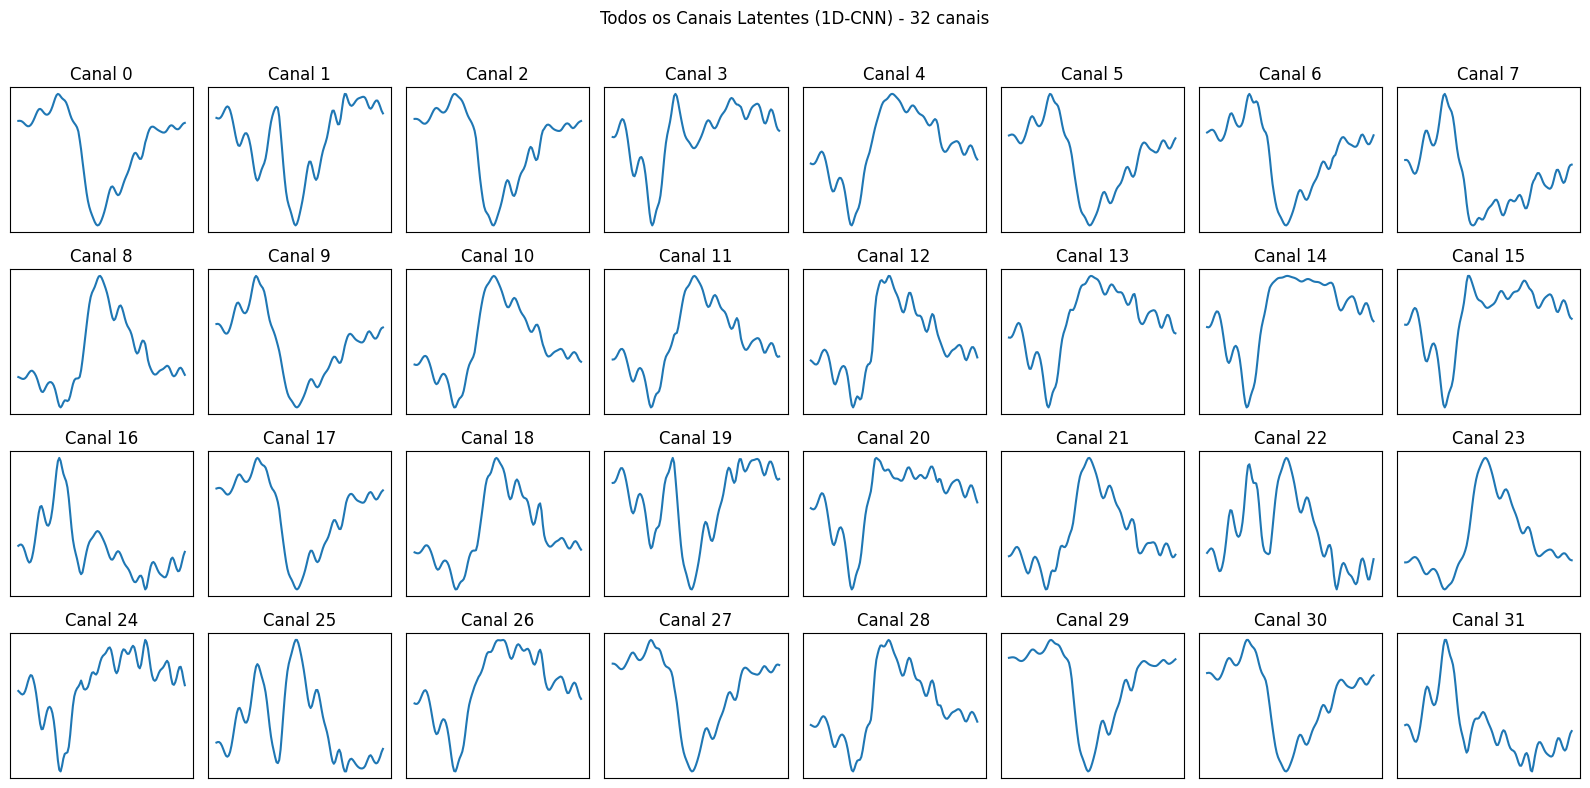

In [263]:
# Ajustado para 32 canais em grade 4x8
n_channels = min(32, latent_to_plot.shape[0])
rows, cols = 4, 8

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
for i in range(rows * cols):
  r, c = divmod(i, cols)
  ax = axes[r, c]
  if i < n_channels:
    ax.plot(latent_to_plot[i])
    ax.set_title(f'Canal {i}')
  else:
    ax.axis('off')  # esconde subplots extras se houver menos de 32 canais
  ax.set_xticks([])
  ax.set_yticks([])

plt.suptitle('Todos os Canais Latentes (1D-CNN) - 32 canais')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Canal latente mais próximo (DTW): 5, distância DTW: 5.38


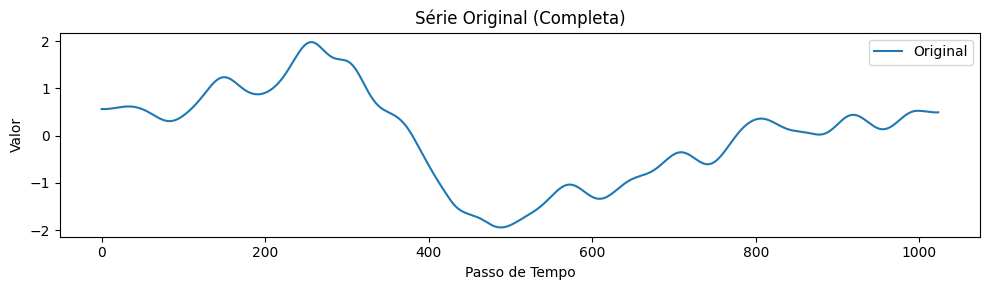

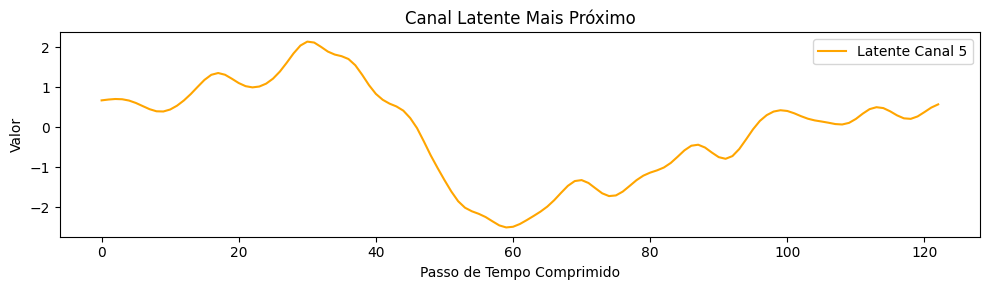

In [264]:
from aeon.distances import dtw_distance
import numpy as np

# original_to_plot: shape [1024]
# latent_to_plot: shape [64, 128]

dtw_distances = []
for i in range(latent_to_plot.shape[0]):
    dist = dtw_distance(original_to_plot, latent_to_plot[i])
    dtw_distances.append(dist)

best_channel = np.argmin(dtw_distances)
print(f"Canal latente mais próximo (DTW): {best_channel}, distância DTW: {dtw_distances[best_channel]:.2f}")

# Figura 1: Série original (completa)
plt.figure(figsize=(10, 3))
plt.plot(original_to_plot, label='Original')
plt.legend()
plt.title('Série Original (Completa)')
plt.xlabel('Passo de Tempo')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()

# Figura 2: Canal latente reduzido (sem resize, laranja)
plt.figure(figsize=(10, 3))
plt.plot(latent_to_plot[best_channel], label=f'Latente Canal {best_channel}', color='orange')
plt.legend()
plt.title('Canal Latente Mais Próximo')
plt.xlabel('Passo de Tempo Comprimido')
plt.ylabel('Valor')
plt.tight_layout()
plt.show()